## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Helper Functions

In [11]:
def fill_missing(series, slots, na_val):
    
    '''
    
    In a series with an expected numerically ascending index, identifies if a particular index value
    is missing and inserts a new entry with such missing index value with the desired na_val.
    
    Finally, reorder the new series to ensure that the inserted index values are in their appropriate 
    position
    
    '''
    
    if series.shape[0] != slots:
        missing_idx = list(set(np.arange(1, slots+1, 1)).difference(series.index))
        for i in missing_idx:
            series[float(i)] = na_val
    
    series = series.sort_index()
    return series

In [13]:
def todd_by_metric(df, metric, city = 'ALL'):
    
    ''' 
    
    For a city and for a traffic metric (movements, capacity, estimated passengers), returns the weekly
    time-of-day distribution (todd) grouped by:
        flights into the city
        flights out of the city
        
    When combined across all cities, for any time of day slot, the total value of the metric for flights in 
    would be the same as the total value of the metric for flights out (for e.g. the total number of 
    arrivals must be equal to the total number of departures). 
    
    However, this may not be true when considering a particular city, i.e. the total number of arrivals in a 
    city may not be the same as the total number of departures. 
    
    '''
    
    _in =[]
    _out = []
    
    if city == 'ALL':
        _in = (df.groupby(['to_time_slot'])[metric].sum())
        _in = fill_missing(_out, 48, 0)
        _out = (df.groupby(['from_time_slot'])[metric].sum())
        _out = fill_missing(_out, 48, 0)
    else:
        idx = [i for i in dat.index if dat['from'][i] == city or dat['to'][i] == city]
        sdat = dat.iloc[idx, :]

        idx_in = [i for i in sdat.index if sdat['to'][i] == city]     # flights into the city
        idx_out = [i for i in sdat.index if sdat['from'][i] == city]  # flights out of the city

        _in = (sdat.loc[idx_in, :].groupby(['to_time_slot'])[metric].sum())
        _in = fill_missing(_in, 48, 0)
        _out = (sdat.loc[idx_out, :].groupby(['from_time_slot'])[metric].sum())
        _out = fill_missing(_out, 48, 0)
    
    return _in, _out
    

In [22]:
def spread_traffic(traffic, sprd_ovr, pass_dir_in = False):
    
    '''
    
    'Spreads' passenger traffic over adjacent timeslots. Expects traffic to be a pandas Series object.
    
    Incoming passengers at an airport start departing from the airport, and do so evenly in sprd_ovr number
    of slots post the timeslot in which their flight arrives. For e.g. for a flight arriving in timeslot 5, 
    the passengers leave the airport evenly starting timeslot 6 and subsequent (sprd_over - 1) timeslots.
    
    Outgoing passengers from an airport start reaching the airpot and do so evenly in sprd_over number
    of slots prior to the timeslot in which their flight leaves. For e.g. for a flight leaving in timeslot 5, 
    the passengers reach the airport evenly in timeslot 4 and preceeding (sprd_over - 1) timeslots.
    
    pass_dir_in is a boolean flag to decide if function needs to spread incoming traffic (True) of outgoing
    traffic
    
    '''
    
    traffic_adj = pd.Series(data = 0, index = traffic.index, dtype = 'float')
    
    if pass_dir_in == True:
        for i in range(1, 49):              # spreading the traffic at the airport on incoming flights
            dist_ = traffic[i]/sprd_ovr
            for j in range(i + 1, i + (sprd_ovr+1)): # spreading the traffic over subsequent timeslots
                if j > 48: j = j - 48
                traffic_adj[j] += dist_
    else:
        for i in range(1, 49):              # spreading the passengers at the airport on outgoing flights
            dist_ = traffic[i]/sprd_ovr
            for j in range((i - sprd_ovr), i):       # spreading the traffic over preceding timeslots
                if j < 1: j = 48 + j
                traffic_adj[j] += dist_
                    
    return traffic_adj

In [24]:
def plot_distbn(psg_traf, city = 'ALL', label = 'Incoming+Outgoing', spline_pts = 100, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) for Time-of-Day distribution of passenger traffic.
    
    psg_traf - List of hourly passenger traffic.
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
    
    x_orig = np.arange(1, 49 ,1)
    x_augm = np.linspace(1, 48, spline_pts)
    spline = make_interp_spline(x_orig, psg_traf, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))      # prevent y from taking a negative value

    plt.xlabel('Hour of the Day')
    plt.ylabel('Passenger Traffic')

    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1))  # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
    
    if city == 'ALL': plt.title('Daily Average Hourly Passenger Traffic - All Cities')
    else: plt.title('Daily Average Hourly Passenger Traffic in %s' % codes_to_city[city])
        
    plt.plot(x_augm, y_axis, label = label)
    plt.legend()
    
    return        

In [37]:
def traf_at_loc(psg_traf, time_to_airport):
    
    '''
    
    time_to_airport - Time taken in hours from the location to reach the airport. 
                      If negative, implies time taken from airport to reach the location.
    '''
    
    psg_traf_loc = pd.Series(data = 0, index = psg_traf.index, dtype = 'float')
    timeslots = np.ceil(time_to_airport*2)           # translates time_to_airport into equivalent number of 
                                                     # 1/2 hour slots.
    
    for i in range(1, 49):
        shifted_i = i + timeslots
        if shifted_i > 48: 
            shifted_i = shifted_i - 48
        elif shifted_i < 1:
            shifted_i = 48 + shifted_i
        
        psg_traf_loc[i] = psg_traf[shifted_i]
        
        
    return psg_traf_loc

In [42]:
def plot_distbn_loc(psg_traf, loc, label = 'Both Ways Combined', spline_pts = 300, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) for Time-of-Day distribution of passenger traffic.
    
    psg_traf - List of hourly passenger traffic.
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
    
    x_orig = np.arange(1, 49 ,1)
    x_augm = np.linspace(1, 48, spline_pts)
    spline = make_interp_spline(x_orig, psg_traf, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))      # prevent y from taking a negative value

    plt.xlabel('Hour of the Day')
    plt.ylabel('Passenger Traffic')

    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1))  # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
    
    plt.title('Daily Average Hourly Passenger Traffic at %s' % loc)
        
    plt.plot(x_augm, y_axis, label = label)
    plt.legend()
    
    return        

## Get Data

In [2]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Estimated Passenger Traffic by Timeslot

The following analysis is done for Bengaluru (BLR) but can be replicated for any other city or cities.

#### Passengers on a Flight

Estimate the passenger traffic assuming all passengers are at the airport at the same time as either the incoming flight or the outgoing flight.
<ol>
    <li>Group (separately) all incoming and outgoing flights into Bengaluru, in a week, by the timeslot of their arrival or departure.
        <ul>
            <li>We divide a 24 hour day into 48 half hour slots indexed 1 thru 48
        </ul>
    <li>For every timeslot, calculate the weekly estimated passenger traffic in Bengaluru. 
        <ul>
            <li>The estimated weekly incoming passengers and outgoing passengers for a timeslot are separately tracked.
        </ul>
</ol>

In [20]:
city = 'BLR'
pass_in, pass_out = todd_by_metric(dat, metric = 'weekly_est_pass', city = city)

print('Weekly estimated incoming passengers distribution in Bengaluru in timeslots 1 to 5:\n')
print(pass_in[:5], '\n')
print('Weekly estimated outgoing passengers distribution in Bengaluru in timeslots 1 to 5:\n')
print(pass_out[:5])

Weekly estimated incoming passengers distribution in Bengaluru in timeslots 1 to 5:

to_time_slot
1.0    7943.0
2.0    4912.0
3.0    6189.0
4.0    3375.0
5.0     692.0
Name: weekly_est_pass, dtype: float64 

Weekly estimated outgoing passengers distribution in Bengaluru in timeslots 1 to 5:

from_time_slot
1.0    2124.0
2.0    1977.0
3.0    2336.0
4.0    1817.0
5.0       0.0
Name: weekly_est_pass, dtype: float64


#### Adjusted Distribution for Passenger Traffic at the Airport

<ul>
    <li>Passengers arrive at the airport in advance for their departing flight time and take time to leave the airport and do so later than their arriving flight time.
    <li>The passenger traffic distribution is adjusted to reflect this passenger movement behaviour.
</ul>

In [35]:
in_slots = 2        # Incoming passengers leave the airport in these number of timeslots subsequent to the
                    # flight arrival timeslot
out_slots = 4       # Outgoing passengers reach the airport in these number of timeslots prior to the
                    # flight departure timeslot

pass_in_adj = spread_traffic(pass_in, in_slots, True)
pass_out_adj = spread_traffic(pass_out, out_slots)

print('Weekly estimated incoming passengers adjusted distribution in Bengaluru in timeslots 1 to 5:\n')
print(pass_in[:5], '\n')
print('Weekly estimated outgoing passengers adjusted distribution in Bengaluru in timeslots 1 to 5:\n')
print(pass_out[:5], '\n')

Weekly estimated incoming passengers adjusted distribution in Bengaluru in timeslots 1 to 5:

to_time_slot
1.0    7943.0
2.0    4912.0
3.0    6189.0
4.0    3375.0
5.0     692.0
Name: weekly_est_pass, dtype: float64 

Weekly estimated outgoing passengers adjusted distribution in Bengaluru in timeslots 1 to 5:

from_time_slot
1.0    2124.0
2.0    1977.0
3.0    2336.0
4.0    1817.0
5.0       0.0
Name: weekly_est_pass, dtype: float64 



<ul>
    <li>We average the weekly traffic and then plot the daily adjusted incoming, outgoing and total estimated passenger traffic by hour of the day.
</ul>

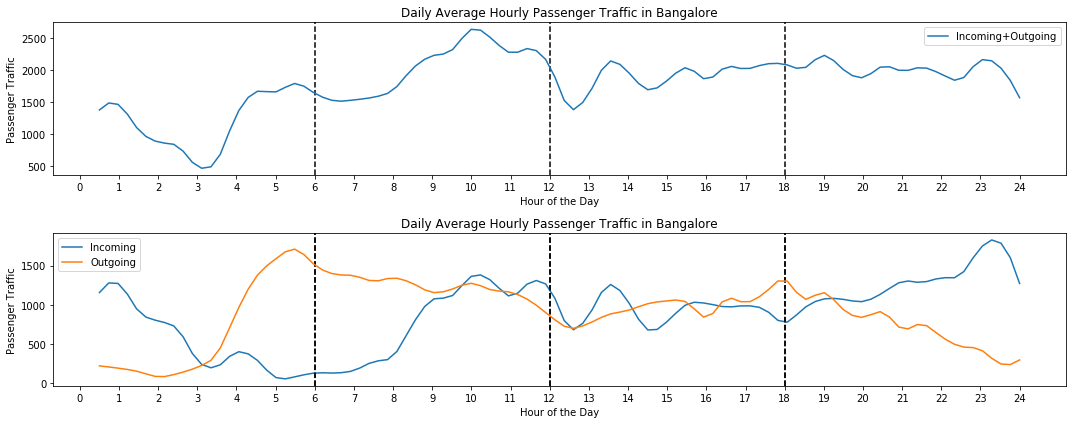

In [36]:
pass_in_adj_day = pass_in_adj/7
pass_out_adj_day = pass_out_adj/7
pass_total_adj_day = [sum(x) for x in zip(pass_in_adj_day, pass_out_adj_day)]

plt.figure(figsize = (15, 6))

plt.subplot(2, 1, 1)
plot_distbn(pass_total_adj_day, city = city)

plt.subplot(2, 1, 2)
plot_distbn(pass_in_adj_day, label = 'Incoming', city = city)
plot_distbn(pass_out_adj_day, label = 'Outgoing', city = city)

plt.tight_layout()
plt.show()

This adjusted traffic distribution pattern should inform the staffing and resourcing strategies for various service providers catering to the passengers. For e.g. the number of gate security lanes and gate security personnel frisking the outgoing passengers or the demand for meals (breakfast, lunch and dinner).

#### Distrubution of Passenger Traffic at a Location

<ul>
    <li>The distribution of passenger traffic at the airport can be used to model the distribution of passenger traffic passing through at other locations to and from the airport.
        <ul>
            <li>For e.g. in Bengaluru, most of the traffic from and to the airport will pass through the Hebbal Junction. Outgoing passengers will be at this junction earlier than they are estimated to be at the airport and incoming passengers will be at this junction later than they are estimated to be at the airport.
        </ul>
    <li>Adjust the distribution of passenger traffic at the airport by the time it takes to travel to and from a specific location to get the distribution of passenger traffic at the location.
    <li>Plot the estimated daily average total, incoming and outgoing passenger traffic by hour of the day at Hebbal Junction.
</ul>

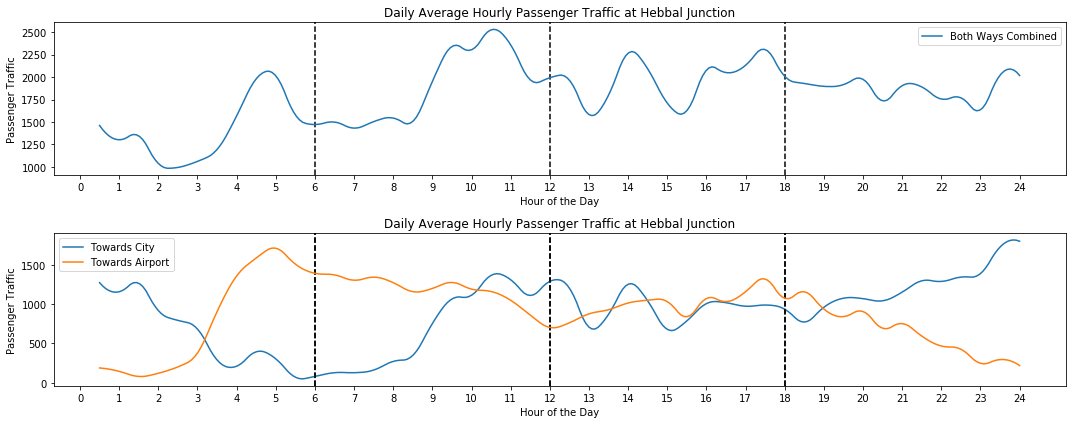

In [44]:
pass_in_loc = traf_at_loc(pass_in_adj_day, -0.5)
pass_out_loc = traf_at_loc(pass_out_adj_day, 0.5)
pass_total_loc = [sum(x) for x in zip(pass_in_loc, pass_out_loc)]

plt.figure(figsize = (15, 6))

plt.subplot(2, 1, 1)
plot_distbn_loc(pass_total_loc, loc = 'Hebbal Junction')

plt.subplot(2, 1, 2)
plot_distbn_loc(pass_in_loc, loc = 'Hebbal Junction', label = 'Towards City')
plot_distbn_loc(pass_out_loc, loc = 'Hebbal Junction', label = 'Towards Airport')

plt.tight_layout()
plt.show()

This traffic distribution pattern at a location should inform the staffing and resourcing strategies for various service providers. For e.g. the traffic management strategy at the Hebbal Junction.

#### Distribution of Passenger Traffic - Different Moving Windows

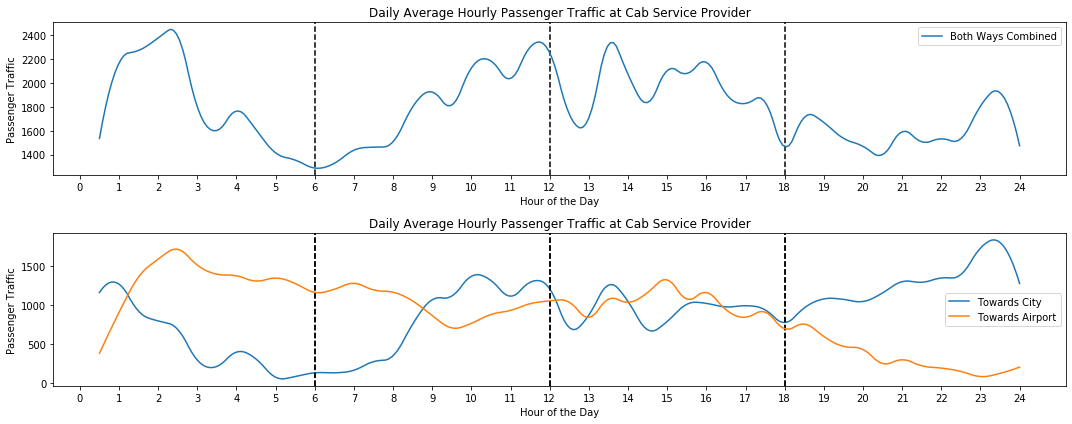

In [46]:
pass_in_loc = traf_at_loc(pass_in_adj_day, 0)
pass_out_loc = traf_at_loc(pass_out_adj_day, 3)
pass_total_loc = [sum(x) for x in zip(pass_in_loc, pass_out_loc)]

plt.figure(figsize = (15, 6))

plt.subplot(2, 1, 1)
plot_distbn_loc(pass_total_loc, loc = 'Cab Service Provider')

plt.subplot(2, 1, 2)
plot_distbn_loc(pass_in_loc, loc = 'Cab Service Provider', label = 'Towards City')
plot_distbn_loc(pass_out_loc, loc = 'Cab Service Provider', label = 'Towards Airport')

plt.tight_layout()
plt.show()